In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
cd drive/MyDrive

/content/drive/MyDrive


In [3]:
# !pip install sentencepiece
!pip install bertopic

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.4/143.4 kB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 67.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.8/90.8 kB 11.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 9.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Using cached Cython-0.29.36-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.manylinux_2_24_x86_64.whl (1.9 MB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 107.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 73.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 37.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 70.3 MB/s eta 0:00:00
  Preparing metadata

In [4]:
from tqdm import tqdm
from sklearn.feature_extraction.text import CountVectorizer
from bertopic import BERTopic
import os
import json

In [5]:
import os
import json
import re
from zipfile import ZipFile

cond = re.compile('[가-힣]+')

def get_data_from_zip(zip_name):
    zip_file_path = '/content/drive/MyDrive/jolnon/' + zip_name + '.zip'
    extract_path = '/content/' + zip_name

    with ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)

    result = []
    for name in os.listdir(path=extract_path):
        file_path = os.path.join(extract_path, name)
        if os.path.isdir(file_path):
            for name in os.listdir(path=file_path):
                with open(file_path + '/' + name, 'r', encoding='utf-8') as f:
                    data = json.load(f)
                    valid = []
                    for d in data['content'].split('\n'):
                        res = []
                        for word in d.split(' '):
                            if cond.match(word) != None:
                                res.append(word)
                        d = ' '.join(res)
                        if d and not d.replace(' ', '').isdecimal():
                            valid.append(d)
                    result.append('\n'.join([data['title']] + valid))
        else:
            with open(extract_path + '/' + name, 'r', encoding='utf-8') as f:
                data = json.load(f)
                valid = []
                for d in data['content'].split('\n'):
                    res = []
                    for word in d.split(' '):
                        if cond.match(word) != None:
                            res.append(word)
                    d = ' '.join(res)
                    if d and not d.replace(' ', '').isdecimal():
                        valid.append(d)
                result.append('\n'.join([data['title']] + valid))
    return result


In [6]:
import random
random.seed(42)
galleries = ['animal','tree']
dataset = []
for e in galleries:
  dataset.append([get_data_from_zip(e)])
cocktail = []
for data in dataset:
  for sen in data:
    cocktail+=sen

In [7]:
def remove_words(sentence, word):
    return ' '.join([w.replace(word, '') for w in sentence.split()])
    # return ' '.join([w for w in sentence.split() if w != word])
stopwords = ['-dc', 'official', 'App', '이미지' ,'순서','저장','.jpg','.png','.txt','.gif']#['ㅋㅋ', 'ex', '나는', 'on', '이미지', '순서', '오늘', '일단', 'and', '이야', '그리고', '내일', '그냥', '000', '조금', '살짝', 'ㅇㅇ', 'ㅈㄱㄴ', '있음', '이거', '내가', '칵하하하', '칵하핫', '근데', '지듣노', 'youtube ', '야스중', '우흥', '한다', 'ㅎㅎ', 'ㅠㅠ', '로오오오오오옹', '하고', '아침', '것도', '추천', '혹시', '새낀데', '같다']
for i in range(len(cocktail)):
  for j in range(len(stopwords)):
    cocktail[i] = remove_words(cocktail[i],stopwords[j])

In [8]:
import collections

def remove_top_n_words(data, n):
    words = [word for sentence in data for word in sentence.split(' ')]
    word_count = collections.Counter(words)
    top_n_words = [word for word, _ in word_count.most_common(n)]
    for i in range(len(data)):
        for word in top_n_words:
            if word=='':
                continue
            data[i] = remove_words(data[i], word)
    return data

def remove_empty_sentences(cocktail, real_labels):
  indices = [i for i, sentence in enumerate(cocktail) if sentence.strip() != '']
  cocktail = [cocktail[i] for i in indices]
  real_labels = [real_labels[i] for i in indices]
  return cocktail, real_labels


In [9]:
real_labels = []
for i in range(len(dataset)):
  real_labels += [i] * len(dataset[i][0])
cocktail = remove_top_n_words(cocktail, 0)
cocktail, real_labels = remove_empty_sentences(cocktail, real_labels)

In [ ]:
# !pip install transformers
# from transformers import AutoModel, AutoTokenizer
# model = AutoModel.from_pretrained("klue/roberta-large")
# tokenizer = AutoTokenizer.from_pretrained("klue/roberta-large")

# model = AutoModel.from_pretrained("klue/bert-base")
# tokenizer = AutoTokenizer.from_pretrained("klue/bert-base")

In [10]:
from bertopic.vectorizers import ClassTfidfTransformer
ctfidf_model = ClassTfidfTransformer(reduce_frequent_words=True)
bertopic_model_embed_token = BERTopic(language='multilingual',
                          nr_topics=100,
                          # ctfidf_model=ctfidf_model,
                          top_n_words=1)
# bertopic_model_embed_token = BERTopic(embedding_model=model,
#                                       vectorizer_model=vectorizer,
#                                       ctfidf_model=ctfidf_model,
#                                       nr_topics=100,
#                                       top_n_words=1,
#                                       calculate_probabilities=False)
topics, _ = bertopic_model_embed_token.fit_transform(cocktail)

In [11]:
topic_info = bertopic_model_embed_token.get_topic_info()
number_of_topics = len(topic_info) - 1
print(f"생성된 주제의 수: {number_of_topics}")
lst = []
for index, row in topic_info.iterrows():
    topic_num = row['Topic']
    if topic_num != -1:
        topic_name = row['Name']
        pure_topic_name = "_".join(topic_name.split("_")[1:])
        lst.append(pure_topic_name)
# for i in lst:
#   print(i)

생성된 주제의 수: 99


In [12]:
### Reducing outliers
topics = bertopic_model_embed_token.reduce_outliers(cocktail, topics, strategy="c-tf-idf", threshold=0.1)
topics = bertopic_model_embed_token.reduce_outliers(cocktail, topics, strategy="distributions")

In [13]:
hierarchical_topics = bertopic_model_embed_token.hierarchical_topics(cocktail)

100%|██████████| 98/98 [00:00<00:00, 110.74it/s]


In [ ]:
# Hierarchical topics
# linkage_function = lambda x: sch.linkage(x, 'single', optimal_ordering=True)
# hierarchical_topics = bertopic_model_embed_token.hierarchical_topics(cocktail, linkage_function=linkage_function)

In [14]:
bertopic_model_embed_token.visualize_hierarchy(hierarchical_topics=hierarchical_topics)

In [15]:
# 주제, 분기점 별 클러스터 구성 라벨 수
verify = True
table = [[0 for r in range(2)] for t in range(max([int(x) for x in hierarchical_topics['Parent_ID']]) + 1)]
if verify:
  for j in range(number_of_topics):
    for i in range(len(topics)):
      if topics[i]==j:
        table[j][real_labels[i]]+=1
  for j in range(number_of_topics, len(table)):
    row = hierarchical_topics[hierarchical_topics['Parent_ID'] == str(j)].iloc[0]
    left, right = int(row['Child_Left_ID']), int(row['Child_Right_ID'])
    for i in range(len(table[0])):
      table[j][i] += table[left][i] + table[right][i]

In [16]:
df = hierarchical_topics
selected_topics_ids = set()
for index, row in df[df['Distance'] >= 1].iterrows():
    left_child = df[df['Parent_ID'] == row['Child_Left_ID']]
    if not left_child.empty and left_child.iloc[0]['Distance'] < 1:
        selected_topics_ids.add(row['Child_Left_ID'])

    right_child = df[df['Parent_ID'] == row['Child_Right_ID']]
    if not right_child.empty and right_child.iloc[0]['Distance'] < 1:
        selected_topics_ids.add(row['Child_Right_ID'])
selected_topics_ids = list(selected_topics_ids)

In [17]:
post_counts = [0 for i in range(number_of_topics)]
for i in range(len(post_counts)):
    post_counts[i] = topics.count(i)

In [18]:
selected_topic_names=[]
for topic_id in selected_topics_ids:
    topic_name = df[df['Parent_ID'] == topic_id]['Parent_Name'].iloc[0]
    selected_topic_names.append(topic_name)

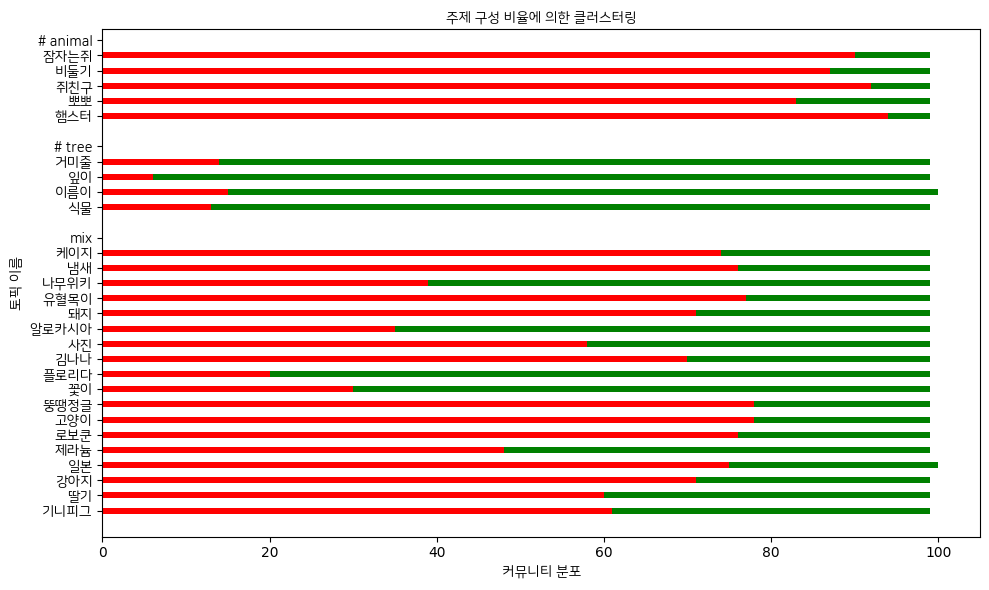

animal: ['잠자는쥐', '비둘기', '쥐친구', '뽀뽀', '햄스터'] - 4059
tree: ['거미줄', '잎이', '이름이', '식물'] - 4818
mix: ['케이지', '냄새', '나무위키', '유혈목이', '돼지', '알로카시아', '사진', '김나나', '플로리다', '꽃이', '뚱땡정글', '고양이', '로보쿤', '제라늄', '일본', '강아지', '딸기', '기니피그'] - 10122


In [19]:
import numpy as np
import warnings
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
warnings.filterwarnings("ignore", category=UserWarning, module="matplotlib")

def clusterByRatio(th, table, selected_topics_ids, selected_topic_names, galleries, post_counts):
    selected_topic_counts = [[0, 0] for _ in range(len(selected_topics_ids))]
    for i in range(len(selected_topics_ids)):
        selected_topic_counts[i][0] += table[int(selected_topics_ids[i])][0]
        selected_topic_counts[i][1] += table[int(selected_topics_ids[i])][1]
    dic = dict()
    n_clusters = len(galleries) + 1
    clusters = [[] for _ in range(n_clusters)]
    name2idx = dict()
    for i in range(len(selected_topics_ids)):
        name2idx[selected_topic_names[i]] = int(selected_topics_ids[i])
        ratio = selected_topic_counts[i][0] / sum(selected_topic_counts[i])
        if ratio > (1 - th):
            clusters[0].append(selected_topic_names[i])
        elif ratio < th:
            clusters[1].append(selected_topic_names[i])
        else:
            clusters[2].append(selected_topic_names[i])
        dic[selected_topic_names[i]]=[ratio, 1-ratio, ]
    font_path = '/content/drive/MyDrive/NanumSquareRoundR.ttf'
    fontprop = fm.FontProperties(fname=font_path, size=10)
    plt.rcParams["font.family"] = fontprop.get_name()
    plt.rcParams['axes.unicode_minus'] = False

    fig, ax = plt.subplots(figsize=(10, 6))

    y_positions = []
    y_labels = []

    current_y = 0
    bar_width = 0.4

    for index, cluster in enumerate(clusters):
        y_positions.append(current_y)
        cluster_name ='# ' + galleries[index] if index<len(galleries) else 'mix'
        y_labels.append(cluster_name)
        for topic in cluster:
            current_y -= 1
            y_positions.append(current_y)
            y_labels.append(topic)
            ax.barh(current_y, int(dic[topic][0]*100), color='r', height=bar_width, label=topic)
            ax.barh(current_y, int(dic[topic][1]*100), color='g', left=int(dic[topic][0]*100), height=bar_width)
        current_y -= 2

    ax.set_yticks(y_positions)
    ax.set_yticklabels(y_labels, fontproperties=fontprop)
    ax.set_xlabel('커뮤니티 분포', fontproperties=fontprop)
    plt.title("주제 구성 비율에 의한 클러스터링", fontproperties=fontprop)
    plt.ylabel("토픽 이름", fontproperties=fontprop)

    plt.tight_layout()
    plt.show()

    for idx, r in enumerate(clusters):
        name = galleries[idx] if idx < len(galleries) else 'mix'
        val = sum([sum(table[name2idx[x]]) for x in r])
        print(f'{name}: {r} - {val}')

    plt.show()

threshold = 0.2
if verify:
  clusterByRatio(threshold, table, selected_topics_ids, selected_topic_names, galleries, post_counts)


In [20]:
!pip install fasttext
import fasttext
from sklearn.cluster import KMeans
import numpy as np
from gensim import models

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.8/68.8 kB 1.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Using cached pybind11-2.11.1-py3-none-any.whl (227 kB)
  Created wheel for fasttext: filename=fasttext-0.9.2-cp310-cp310-linux_x86_64.whl size=4199769 sha256=f277e9c0779eaee3573c9f894f6c4475523badb5458546db0f17d5b6de97bf9b
  Stored in directory: /root/.cache/pip/wheels/a5/13/75/f811c84a8ab36eedbaef977a6a58a98990e8e0f1967f98f394
Successfully built fasttext


In [ ]:
model_path = '/content/drive/MyDrive/jolnon/cc.ko.100.bin'
m_fasttext = models.fasttext.load_facebook_model(model_path)

ERROR:gensim.models._fasttext_bin:failed to decode invalid unicode bytes b'\xed\xa1\x9c'; replacing invalid characters, using '\\xed\\xa1\\x9c'
ERROR:gensim.models._fasttext_bin:failed to decode invalid unicode bytes b'\xed\xb0\x80'; replacing invalid characters, using '\\xed\\xb0\\x80'
ERROR:gensim.models._fasttext_bin:failed to decode invalid unicode bytes b'\xed\xa7\x80'; replacing invalid characters, using '\\xed\\xa7\\x80'
ERROR:gensim.models._fasttext_bin:failed to decode invalid unicode bytes b'\xed\xb8\xb0'; replacing invalid characters, using '\\xed\\xb8\\xb0'
ERROR:gensim.models._fasttext_bin:failed to decode invalid unicode bytes b'\xed\xa0\x9c'; replacing invalid characters, using '\\xed\\xa0\\x9c'
ERROR:gensim.models._fasttext_bin:failed to decode invalid unicode bytes b'\xed\xa6\xac'; replacing invalid characters, using '\\xed\\xa6\\xac'
ERROR:gensim.models._fasttext_bin:failed to decode invalid unicode bytes b'\xed\xb3\xb5'; replacing invalid characters, using '\\xed\\xb

In [ ]:
embeddings = [m_fasttext.wv[selected_topic_names[i]] for i in range(len(selected_topic_names))]
embed_ids = [selected_topics_ids[i] for i in range(len(selected_topic_names))]

embeddings = np.array(embeddings)


In [ ]:
import numpy as np
import warnings
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
warnings.filterwarnings("ignore", category=UserWarning, module="matplotlib")


def showDistribution(n, verify):
  n_clusters=n
  kmeans = KMeans(n_clusters=n_clusters, random_state=42).fit(embeddings)

  clustered_topics = [[] for _ in range(n_clusters)]
  clustered_topics_name = [[] for _ in range(n_clusters)]
  clustered_topics_count = [[] for _ in range(n_clusters)]

  for i, label in enumerate(kmeans.labels_):
    clustered_topics[label].append(embed_ids[i])
    clustered_topics_name[label].append(selected_topic_names[i])
    clustered_topics_count[label].append(post_counts[i])
  for r in clustered_topics_name:
    print(r)
  cluster_sums = []
  for cluster in clustered_topics:
    total_sum = 0
    for parent_id in cluster:
      row = hierarchical_topics[hierarchical_topics['Parent_ID'] == parent_id].iloc[0]
      topic_ids = row['Topics']
      cluster_sum = sum(post_counts[topic_id] for topic_id in topic_ids)
      total_sum += cluster_sum
    cluster_sums.append(total_sum)
  print(cluster_sums)
  if verify:
    clustered_count = [[0, 0] for _ in range(n_clusters)]
    for i in range(n_clusters):
      for j in clustered_topics[i]:
        clustered_count[i][0] += table[int(j)][0]
        clustered_count[i][1] += table[int(j)][1]

    for i in range(n_clusters):
      l, r = clustered_count[i][0], clustered_count[i][1]
      # print(f'Cluster #{i+1}: ({l + r}) - [{100 * l / (l + r):.2F}, {100 * r / (l + r):.2F}]')
      for j in range(len(clustered_topics[i])):
        k = clustered_topics[i][j]
        l, r = table[int(k)][0], table[int(k)][1]
        # print(f'\t- {clustered_topics_name[i][j]} ({l + r}): [{100 * l / (l + r):.2F}, {100 * r / (l + r):.2F}]')
    clusters = []

    for i in range(n_clusters):
      cluster_info = {}
      l, r = clustered_count[i][0], clustered_count[i][1]
      cluster_info['name'] = f'Cluster #{i+1}'
      cluster_info['value'] = l + r
      cluster_info['distribution'] = [100 * l / (l + r), 100 * r / (l + r)]

      topics_list = []
      for j in range(len(clustered_topics[i])):
        topic_info = {}
        k = clustered_topics[i][j]
        l, r = table[int(k)][0], table[int(k)][1]
        topic_info['name'] = clustered_topics_name[i][j]
        topic_info['value'] = l + r
        topic_info['distribution'] = [100 * l / (l + r), 100 * r / (l + r)]
        topics_list.append(topic_info)

      cluster_info['topics'] = topics_list
      clusters.append(cluster_info)

    font_path = '/content/drive/MyDrive/NanumSquareRoundR.ttf'
    fontprop = fm.FontProperties(fname=font_path, size=10)
    plt.rcParams["font.family"] = fontprop.get_name()
    plt.rcParams['axes.unicode_minus'] = False

    def sort_topics_by_distribution(cluster):
      cluster['topics'] = sorted(cluster['topics'], key=lambda x: x['distribution'][0], reverse=True)

    for cluster in clusters:
      sort_topics_by_distribution(cluster)

    fig, ax = plt.subplots(figsize=(10, 6))

    y_positions = []
    y_labels = []

    current_y = 0
    bar_width = 0.4

    for cluster in clusters:
      y_positions.append(current_y)
      y_labels.append(cluster['name'])
      for topic in cluster['topics']:
        current_y -= 1
        y_positions.append(current_y)
        y_labels.append(topic['name'])
        ax.barh(current_y, topic['distribution'][0], color='r', height=bar_width, label=topic['name'])
        ax.barh(current_y, topic['distribution'][1], color='g', left=topic['distribution'][0], height=bar_width)
      current_y -= 2

    ax.set_yticks(y_positions)
    ax.set_yticklabels(y_labels, fontproperties=fontprop)
    ax.set_xlabel('커뮤니티 분포', fontproperties=fontprop)
    plt.title("FastText 이용 클러스터링 결과", fontproperties=fontprop)
    plt.ylabel("토픽 이름", fontproperties=fontprop)

    plt.tight_layout()
    plt.show()

In [ ]:
showDistribution(3, verify)